In [55]:
import diffrax
import equinox as eqx
import jax.random as jrand
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random, vmap, jit, lax, nn, Array

# Define the Sobel kernels
sobel_x = jnp.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = jnp.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

num_channels = 16
hidden_channels = 64
init_size = 40
padding = 16

initializer = nn.initializers.normal(0.0005)

def upd_filt(x, y):
    return (1-y)*nn.sigmoid(32*x)+y*nn.sigmoid(-32*x)
    
class update(eqx.Module):
    mlp: list
    lz: eqx.Module
    #gate: list

    def __init__(self, key, **kwargs):
        super().__init__(**kwargs)
        key1, key2, key3 = random.split(key, 3) 
        self.lz = eqx.nn.Linear(hidden_channels, num_channels, key=key2, use_bias=False)
        self.lz = eqx.tree_at(lambda l: l.weight, self.lz, initializer(random.PRNGKey(42), self.lz.weight.shape, jnp.float32))
        self.mlp =  [eqx.nn.Linear(3 * num_channels, hidden_channels, key=key1, use_bias=False),
                    nn.swish,
                    self.lz,
                    nn.tanh]
        #self.gate =  [eqx.nn.Linear(48, hidden_channels, key=key2, use_bias=False),
         #           nn.swish,
          #          eqx.nn.Linear(hidden_channels, num_channels, key=key3, use_bias=False),
           #         nn.sigmoid]

        
    def __call__(self, t, y, args):
        dx = jsp.signal.convolve(y, sobel_x[...,None], mode='same', method='auto', precision=None)
        dy = jsp.signal.convolve(y, sobel_y[...,None], mode='same', method='auto', precision=None)
        perceive = jnp.concatenate([dx, dy, y], axis=-1)
        perceive = jnp.reshape(perceive, (-1, 3 * num_channels))
        print(perceive.shape)
        for layer in self.mlp:
            x = vmap(layer)(perceive)
        #for layer2 in self.gate:
         #   gate = vmap(layer2)(perceive)
        #gate = jnp.reshape(gate, (72, 72, num_channels))
        x = jnp.reshape(x, (72, 72, num_channels))
        return x * upd_filt(x, y) 
        #return x


class CoTiNCA(eqx.Module):
    func: eqx.Module

    def __init__(self, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = update(key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys


In [68]:
target_img.shape

(72, 72, 4)

In [ ]:
import requests
import PIL.Image, PIL.ImageDraw
import io
import numpy as np
init_size = 40

def load_image(url, max_size=init_size):
    r = requests.get(url)
    img = PIL.Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
    return load_image(url)

#target_img = load_emoji("🍇")
#target_img = load_emoji("🕌")
target_img = load_emoji("🍓")
#target_img = load_emoji("⚓")

#target_img = load_emoji("😅")
#target_img = load_emoji("🦪")

target_img = jnp.pad(target_img,[(padding,padding),(padding,padding),(0,0)])

In [16]:
import numpy as np

In [21]:
import matplotlib.pyplot as plt
import optax, time

target_img = jnp.pad(target_img,[(padding,padding),(padding,padding),(0,0)])

x_key, y_key, model_key = jrand.split(jrand.PRNGKey(0), 3)

init_config = jnp.array([[0,1,0,1,0.2],[0,0,1,1,0.2],[0.3,0.4,0,0.2,0],[0,1,0.6,1,0.2],[0,0,1,0,0.2]])
init_config = jnp.tile(init_config[...,None],reps=(1,1,num_channels))

seed = jnp.pad(target_img,[(0,0),(0,0),(0,12)])
h, w = seed.shape[:2]
seed2 = np.zeros([h, w, num_channels], np.float32)
seed2[h//2, w//2, 3:] = 1.0
seed2 = jnp.array(seed2)
#cells = model(jnp.array([0,1,2,3,4,5,6,7]),seed)

ts = jnp.array([0,1,2,3,4,5,6,7])

seed2.shape

(72, 72, 16)

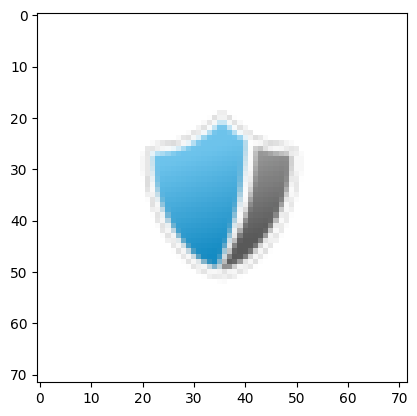

In [22]:
plt.imshow(seed[...,:4])
empty_mask = jnp.sum(seed,axis=-1)<0.02
#plt.imshow(empty_mask)
#plt.imshow((seed*empty_mask[...,None])[...,:4])

In [28]:
def loss(out, target):
    recon_loss2 = jnp.mean((out[...,:4]-target[...,:4])**2)
    recon_loss1 = jnp.mean(jnp.abs(out[...,:4]-target[...,:4]))
    empty_penalty = jnp.mean((out*empty_mask[...,None])**2)
    return 0.2*recon_loss2+0.8*recon_loss1+empty_penalty

@eqx.filter_value_and_grad
def grad_loss(model, ts, inits, target):
   # outs = vmap(model,in_axes=(None,0))(ts,inits)
    #outs = jnp.concatenate(outs, axis=0)
    outs = model(ts,inits)
    outs2 = model(ts[::2],target)
    outs = jnp.concatenate([outs,outs2],axis=0)
    return jnp.mean(vmap(jit(loss), in_axes=(0,None))(outs, target))

#jnp.array([0,1,2,3,4,5,6,7])[None][0]


@eqx.filter_jit
def make_step(ts, inits, target, model, opt_state):
        loss, grads = grad_loss(model, ts, inits, target)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

In [31]:

minv = 4
maxv = 32
glide = 32
steps = 300

model1 = CoTiNCA(key=model_key)

schedule = optax.exponential_decay(0.001, steps, 0.25, transition_begin=0, staircase=False, end_value=None)
optim = optax.adabelief(schedule)
opt_state = optim.init(eqx.filter(model1, eqx.is_inexact_array))

#ts = minv+jnp.arange(24)/(maxv+minv)
for i in range(steps):
    #n_key, x_key = random.split(x_key, 2)
    ts = jnp.sort(jrand.uniform(x_key, shape=(36,),minval=minv,maxval=maxv))
    loss_v, model1, opt_state = make_step(ts, seed2, seed, model1, opt_state)
    if i%10 == 1: 
        print(i, loss_v)

TypeError: dot_general requires contracting dimensions to have the same shape, got (64,) and (48,).

In [ ]:
for i in range(pers_steps):
    

In [ ]:
make_step(jnp.array([0,10,20,30,40,50,60,70,80,90,100]), seed2, seed, model1, opt_state)

In [106]:
#cells = model1(jnp.array([0,10,20,30,40,50,60,70,80,90,100,110,120,130]),seed2)


In [97]:
target_img.shape

(72, 72, 4)

In [77]:
ys = jnp.tile(target_img, reps=(32,1,1,1))[None,...]
ts = jnp.sort(jrand.uniform(x_key, shape=(32,),minval=2,maxval=6))[None,...]
ys.shape

(1, 32, 72, 72, 4)

In [ ]:
import optax, time

def main():
    
    x_key, y_key, model_key, loader_key = jrand.split(jrand.PRNGKey(0), 4)

    model = CoTiNCA(key=model_key)





In [4]:
x_key, y_key, model_key, loader_key = jrand.split(jrand.PRNGKey(0), 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


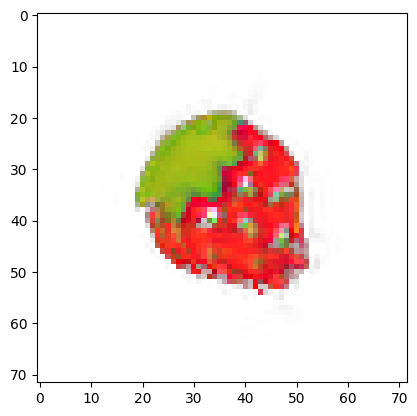

In [142]:
cells = model1(jnp.arange(33)*4,seed2)
plt.imshow(cells[30][:,:,0:4])
#cells[4][:,:,:4]

In [22]:
cells.shape

(14, 72, 72, 16)

In [85]:
jnp.mean((cells[4][...,:4]-seed[...,:4])**2)

Array(0.08533505, dtype=float32)

In [ ]:
grad_loss(model, jnp.array([10,20,30]), seed2, target_img)

In [95]:
jnp.sum(vmap(loss, in_axes=(0,None))(cells,target_img))

Array(0.7679476, dtype=float32)

In [93]:
cells[0].shape

(72, 72, 16)

In [143]:
eqx.tree_serialise_leaves("stbr_growing.eqx", model1)

In [147]:
model1 = eqx.tree_deserialise_leaves("stbr_growing.eqx", model1)

In [327]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [33]:
import numpy as np
cell2 = model1(jnp.arange(256)/8,seed2)
np.save('anchors',np.array(cell2)[...,:4])

In [4]:
from SSIM import ms_ssim

In [5]:
#grad_ms_ssim = vmap(grad(ms_ssim), in_axes=(None, None, None, None, None, None, None), out_axes=(None, 0, 1))

# Example usage
img1 = seed[...,:4]
img2 = seed2[...,:4]
max_val = 1.0
levels = 5
size = 11
sigma = 1.5

loss = ms_ssim(img1, img2, max_val=max_val, levels=levels, size=size, sigma=sigma)
loss

ValueError: in1 and in2 must have the same number of dimensions

In [5]:
test = eqx.nn.Linear(hidden_channels, num_channels, key=x_key, use_bias=False)

In [10]:
test(jnp.zeros((64)))

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)

In [20]:
from PIL import Image
image = Image.open("namerena.png")
target_img = jnp.float32(image)/255.0

import jax.image as jim
#target_img = jnp.array(image)
target_img = jim.resize(target_img, (40,40,4), method="bilinear")

In [56]:
a = update(x_key)

In [57]:
a(14,jnp.ones((72,72,16)),0)

(5184, 48)


TypeError: dot_general requires contracting dimensions to have the same shape, got (64,) and (48,).